# A Guided Tour of LSST Calexps
<br>Owner(s): **David Shupe** ([@stargaser](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@stargaser))
<br>Updated for DC2 by:   Douglas Tucker
<br>Last Verified to Run: **2021-03-09**
<br>Verified Stack Release: **v21.0.0**

We'll inspect a visit image ``calexp`` object, and then show how a coadd image differs.

### Learning Objectives:

After working through this tutorial you should be able to follow some best practices when working with ``calexp`` (image) objects.

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   21.0.0+973e4c9e85 	current v21_0_0 setup


In [2]:
from pprint import pprint

In [3]:
from lsst.daf.persistence import Butler

In [4]:
import lsst.afw.display as afw_display

## Retrieving and inspecting a calexp

We have more than one choice of data set available at NCSA for this tutorial.  In particular, we have an HSC data set (which was used by the original version of this notebook) and the DESC DC2 Run2.2i data set (which comprises a simulated 300 sq deg patch of 5 years of Rubin LSST WFD data).

Here, we create a Butler for the data set we wish to examine and grab the calexp image we are interested in exploring. 

In the first part of the tutorial, we will examine the calibrated exposure (`calexp`) for a single `visit`.  In the second part of the tutorial we will examine the calibrated exposure (`calexp`) for a coadd `patch`.

In the following cell, we provide some examples for both the HSC and the DC2 data sets.  If you wish to try others, the current best way for Gen2 Butler  repositories is to search within the relevant `datadir`'s (or `coadd_datadir`'s) to see what is available.  There should be better available methods to do this for the Gen3 Butler.  

In [5]:
#dataset='HSC'
dataset='DC2'

# Temporary "fix" so one does not need to restart kernel 
#  when switching from DC2 to HSC...
# See also:  https://lsstc.slack.com/archives/C3UCAEW3D/p1584386779038000
#import lsst.afw.image as afwImage
#print(afwImage.Filter.getNames())
#afwImage.Filter.reset()
import lsst.obs.base as obsBase
obsBase.FilterDefinitionCollection.reset()
#print(afwImage.Filter.getNames())


if dataset == 'HSC':
    # Access HSC RC calexp gen2 repository
    datadir = '/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349'
    butler = Butler(datadir)

    # Grab a calexp of interest
    # To see what makes up a dataid for a visit, use:  butler.getKeys('calexp')
    dataId = {'filter': 'HSC-Z', 'ccd': 32, 'visit': 38938}
    calexp = butler.get('calexp', **dataId)

    # Access HST RC gen2 coadd gen2 repository
    # this is a data set that has been specially modified to work with this tutorial
    coadd_datadir = '/project/shared/data/with-globular/'
    coadd_butler = Butler(coadd_datadir)
    
    # Grab a deepCoadd tract,patch
    # To see what makes up a dataid for a coadd patch, use:  coadd_butler.getKeys('deepCoadd_calexp')
    coadd_dataId={'filter':'HSC-I', 'tract':9813, 'patch':'4,4'}
    coadd = coadd_butler.get('deepCoadd_calexp', **coadd_dataId)
    
    
elif dataset == 'DC2':
    # Access DC2 calexp gen2 repository
    datadir = '/datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-calexp-v1/'
    butler = Butler(datadir)

    # Grab a calexp of interest
    # To see what makes up a dataid for a visit, use:  butler.getKeys('calexp')
    dataId = {'filter':'i', 'visit': 512055, 'raftName': 'R20', 'detector': 76}
    calexp = butler.get('calexp', **dataId)
    
    # Access DC2 deepCoadd gen2 repository
    coadd_datadir = '/datasets/DC2/DR6/Run2.2i/patched/2021-02-10/rerun/run2.2i-coadd-wfd-dr6-v1'
    coadd_butler = Butler(coadd_datadir)

    # Grab a deepCoadd tract,patch
    # To see what makes up a dataid for a coadd patch, use:  coadd_butler.getKeys('deepCoadd')
    coadd_dataId = {'filter':'i', 'tract': 4851, 'patch': '1,4'}
    coadd = coadd_butler.get('deepCoadd', **coadd_dataId)
    
else:
    msg = "Unrecognized dataset: %s"%dataset
    raise Exception(msg)

## Image planes / pixel data

In terms of pixel data, a calexp contains an image, a mask, and a variance.

Let's see how to access the image.

In [6]:
calexp.image

lsst.afw.image.image.image.ImageF=[[-3.82834053e+01  3.42491035e+01  6.89195404e+01 ...  1.07490247e+03
   1.04379651e+03  6.83699646e+02]
 [-1.53812799e+01  6.62068939e+01  1.01078018e+02 ...  2.17995459e+03
   1.68644275e+03  1.12186377e+03]
 [ 1.56634842e+02  5.89559097e+01  4.05811920e+01 ...  4.90955322e+03
   3.62566113e+03  2.37405029e+03]
 ...
 [ 1.14947586e+02  1.90423889e+02  3.01270084e+01 ...  1.50209183e+02
  -8.01385345e+01 -5.34359436e+01]
 [ 9.62147808e+00 -2.51698074e+01 -8.81778793e+01 ...  5.51945419e+01
   3.44382763e-01  1.23965187e+02]
 [ 2.03337059e+01  4.38427010e+01  6.95885391e+01 ...  9.42831573e+01
  -1.12728176e+01 -8.36537323e+01]], bbox=(minimum=(0, 0), maximum=(4071, 3999))

To show the pixel data, we will make use of the matplotlib backend to `lsst.afw.display`.

Due to current limitations of this backend, the display must be defined and used in the same code cell, much as matplotlib commands in a notebook must all be in one cell to produce a plot.

In [7]:
%matplotlib inline

If the entire calexp is displayed, masks will be overlaid. Here we will eschew the mask display by showing only the image.

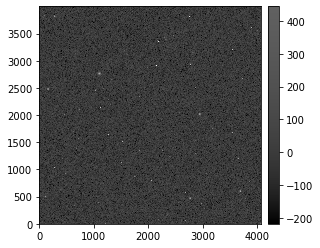

In [8]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.mtv(calexp.image)

To access the pixel values as an array, use the `.array` attribute.

In [9]:
data = calexp.image.array
data

array([[-3.82834053e+01,  3.42491035e+01,  6.89195404e+01, ...,
         1.07490247e+03,  1.04379651e+03,  6.83699646e+02],
       [-1.53812799e+01,  6.62068939e+01,  1.01078018e+02, ...,
         2.17995459e+03,  1.68644275e+03,  1.12186377e+03],
       [ 1.56634842e+02,  5.89559097e+01,  4.05811920e+01, ...,
         4.90955322e+03,  3.62566113e+03,  2.37405029e+03],
       ...,
       [ 1.14947586e+02,  1.90423889e+02,  3.01270084e+01, ...,
         1.50209183e+02, -8.01385345e+01, -5.34359436e+01],
       [ 9.62147808e+00, -2.51698074e+01, -8.81778793e+01, ...,
         5.51945419e+01,  3.44382763e-01,  1.23965187e+02],
       [ 2.03337059e+01,  4.38427010e+01,  6.95885391e+01, ...,
         9.42831573e+01, -1.12728176e+01, -8.36537323e+01]], dtype=float32)

In [10]:
data.__class__

numpy.ndarray

Let's list all the methods for our calexp.

In [11]:
calexp_methods = [m for m in dir(calexp) if not m.startswith('_')]

In [12]:
calexp_methods

['Factory',
 'clone',
 'convertD',
 'convertF',
 'dtype',
 'getBBox',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 'image',
 'mask',
 'maskedImage',
 'readFits',
 'readFitsWithOptions',
 'setDetector',
 'setFilter',
 'setImage',
 'setInfo',
 'setMask',
 'setMaskedImage',
 'setMetadata',
 'setPhotoCalib',
 'setPsf',
 'setVariance',
 'setWcs',
 'setXY0',
 'subset',
 'variance',
 'writeFits',
 'writeFitsWithOptions']

Access the masked Image

In [13]:
calexp.maskedImage

lsst.afw.image.maskedImage.maskedImage.MaskedImageF=(image=[[-3.82834053e+01  3.42491035e+01  6.89195404e+01 ...  1.07490247e+03
   1.04379651e+03  6.83699646e+02]
 [-1.53812799e+01  6.62068939e+01  1.01078018e+02 ...  2.17995459e+03
   1.68644275e+03  1.12186377e+03]
 [ 1.56634842e+02  5.89559097e+01  4.05811920e+01 ...  4.90955322e+03
   3.62566113e+03  2.37405029e+03]
 ...
 [ 1.14947586e+02  1.90423889e+02  3.01270084e+01 ...  1.50209183e+02
  -8.01385345e+01 -5.34359436e+01]
 [ 9.62147808e+00 -2.51698074e+01 -8.81778793e+01 ...  5.51945419e+01
   3.44382763e-01  1.23965187e+02]
 [ 2.03337059e+01  4.38427010e+01  6.95885391e+01 ...  9.42831573e+01
  -1.12728176e+01 -8.36537323e+01]],
mask=[[16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 ...
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]], maskPlaneDict={'BAD': 0, 'BRIGHT_OBJECT': 12, 'CLIPPED': 13, 'CR': 3, 'CROSSTALK': 9, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXA

Access the variance object and the underlying Numpy array

In [14]:
calexp.variance

lsst.afw.image.image.image.ImageF=[[ 5529.8726  5616.9614  5663.55   ...  7108.845   7062.105   6559.281 ]
 [ 5539.506   5639.5845  5674.253  ...  8651.88    7942.262   7168.338 ]
 [ 5778.256   5615.1196  5582.3257 ... 12574.483  10736.043   8967.241 ]
 ...
 [ 5710.0347  5800.673   5565.193  ...  5733.3804  5399.7476  5452.684 ]
 [ 5573.488   5500.1426  5415.214  ...  5601.809   5520.49    5716.0107]
 [ 5618.0747  5623.8003  5654.6514 ...  5682.6187  5546.012   5448.185 ]], bbox=(minimum=(0, 0), maximum=(4071, 3999))

In [15]:
calexp.variance.array

array([[ 5529.8726,  5616.9614,  5663.55  , ...,  7108.845 ,  7062.105 ,
         6559.281 ],
       [ 5539.506 ,  5639.5845,  5674.253 , ...,  8651.88  ,  7942.262 ,
         7168.338 ],
       [ 5778.256 ,  5615.1196,  5582.3257, ..., 12574.483 , 10736.043 ,
         8967.241 ],
       ...,
       [ 5710.0347,  5800.673 ,  5565.193 , ...,  5733.3804,  5399.7476,
         5452.684 ],
       [ 5573.488 ,  5500.1426,  5415.214 , ...,  5601.809 ,  5520.49  ,
         5716.0107],
       [ 5618.0747,  5623.8003,  5654.6514, ...,  5682.6187,  5546.012 ,
         5448.185 ]], dtype=float32)

Access the mask and its underlying array

In [16]:
calexp.mask

lsst.afw.image.image.image.MaskX=[[16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 ...
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'BRIGHT_OBJECT': 12, 'CLIPPED': 13, 'CR': 3, 'CROSSTALK': 9, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXACT_PSF': 14, 'INTRP': 2, 'NOT_DEBLENDED': 10, 'NO_DATA': 8, 'REJECTED': 15, 'SAT': 1, 'SENSOR_EDGE': 16, 'SUSPECT': 7, 'UNMASKEDNAN': 11}

In [17]:
calexp.mask.array

array([[16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       ...,
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16]], dtype=int32)

Get the dimensions of the image, mask and variance

In [18]:
calexp.getDimensions()

Extent2I(4072, 4000)

The image, maskedImage and Exposure objects in `lsst.afw.display` include information on **LSST pixels**, which are 0-based with an optional offset.

For a calexp these are usually zero.

In [19]:
calexp.getXY0()

Point2I(0, 0)

In [20]:
calexp.getX0(), calexp.getY0()

(0, 0)

## Metadata

Access the wcs object

In [21]:
wcs = calexp.getWcs()
wcs

FITS standard SkyWcs:
Sky Origin: (71.415049, -30.487472)
Pixel Origin: (1997.09, 1911.19)
Pixel Scale: 0.199747 arcsec/pixel

The WCS object can be used e.g. to convert pixel coordinates into sky coordinates

In [22]:
wcs.pixelToSky(100.0, 100.0)

SpherePoint(71.27171690184767*geom.degrees, -30.410640494775688*geom.degrees)

Let's try accessing the metadata, and see what (header) keywords we have.

In [23]:
metadata = calexp.getMetadata()
pprint(metadata.toDict())

{'AIRMASS': 1.07580229576959,
 'AMEND': 1.0769458813073,
 'AMSTART': 1.07580229576959,
 'AP_ORDER': 3,
 'A_ORDER': 2,
 'BGMEAN': 3817.86814754402,
 'BGVAR': 1.21432919434056,
 'BP_ORDER': 3,
 'B_ORDER': 2,
 'CHIPID': 'R20_S11',
 'COLORTERM1': 0.0,
 'COLORTERM2': 0.0,
 'COLORTERM3': 0.0,
 'CR_SEED': '2135007486',
 'EXPINFO_V': 1,
 'GAUSFWHM': 0.4,
 'HAEND': 26.2128523945386,
 'HASTART': 26.0875118154903,
 'IMSIMVER': 'v0.6.1',
 'INSTRUME': 'CAMERA',
 'ISR_OSCAN_LEVELC00': 999.591792656587,
 'ISR_OSCAN_LEVELC01': 999.622240172321,
 'ISR_OSCAN_LEVELC02': 999.561769616027,
 'ISR_OSCAN_LEVELC03': 999.511755057408,
 'ISR_OSCAN_LEVELC04': 999.567079741379,
 'ISR_OSCAN_LEVELC05': 999.559271343121,
 'ISR_OSCAN_LEVELC06': 999.587752355316,
 'ISR_OSCAN_LEVELC07': 999.519493177388,
 'ISR_OSCAN_LEVELC10': 999.561030383091,
 'ISR_OSCAN_LEVELC11': 999.579004329004,
 'ISR_OSCAN_LEVELC12': 999.528475711893,
 'ISR_OSCAN_LEVELC13': 999.638504155125,
 'ISR_OSCAN_LEVELC14': 999.522670721592,
 'ISR_OSCAN_LE

In [24]:
#metadata.get('CCDTEMP')
metadata.get('TELESCOP')

'LSST'

## Better metadata: ExposureInfo and VisitInfo

For many purposes, information about an exposure is obtainable via the ExposureInfo and VisitInfo classes.

In [25]:
calexp_info = calexp.getInfo()

In [26]:
visit_info = calexp_info.getVisitInfo()

In [27]:
[m for m in dir(visit_info) if not m.startswith('_')]

['getBoresightAirmass',
 'getBoresightAzAlt',
 'getBoresightHourAngle',
 'getBoresightParAngle',
 'getBoresightRaDec',
 'getBoresightRotAngle',
 'getDarkTime',
 'getDate',
 'getEra',
 'getExposureId',
 'getExposureTime',
 'getLocalEra',
 'getObservatory',
 'getRotType',
 'getUt1',
 'getWeather',
 'isPersistable',
 'readFits',
 'writeFits']

Obtain weather information for this visit

In [28]:
visit_info.getWeather()

Weather(nan, nan, 40)

Check if this calexp has a valid polygon.

In [29]:
calexp_info.hasValidPolygon()

False

For the HSC data set example, there is a valid polygon, the `polygon` variable in the next cell gets the polygon values.

For the DESC DC2 data set example, however, there is not a valid polygon; so the `polygon` variable in the next cell returns `None`.

In [30]:
polygon = calexp_info.getValidPolygon()
print(polygon)

None


The calexp is not a coadd so this method returns False.

In [31]:
calexp_info.hasCoaddInputs()

False

Does the calexp contain transmission curve information?

In [32]:
calexp_info.hasTransmissionCurve()

False

Does the calexp contain a World Coordinate System?

In [33]:
calexp_info.hasWcs()

True

Does the calexp have a detector?

In [34]:
calexp_info.hasDetector()

True

In [35]:
[m for m in dir(calexp_info.getDetector()) if not m.startswith('_')]

['Builder',
 'InCameraBuilder',
 'PartialRebuilder',
 'fromConfig',
 'getAmplifiers',
 'getBBox',
 'getCenter',
 'getCorners',
 'getCrosstalk',
 'getId',
 'getName',
 'getNativeCoordSys',
 'getOrientation',
 'getPhysicalType',
 'getPixelSize',
 'getSerial',
 'getTransform',
 'getTransformMap',
 'getType',
 'hasCrosstalk',
 'hasTransform',
 'isPersistable',
 'makeCameraSys',
 'readFits',
 'rebuild',
 'transform',
 'writeFits']

Does the calexp have an aperture correction map?

In [36]:
calexp_info.hasApCorrMap()

True

Let's get the aperture correction map and print some information about it

In [37]:
apCorrMap = calexp_info.getApCorrMap()

In [38]:
for k in apCorrMap.keys():
    print(k, apCorrMap.get(k))

base_GaussianFlux_instFlux ChebyshevBoundedField ((3,3,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
base_GaussianFlux_instFluxErr ChebyshevBoundedField ((1,1,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
base_PsfFlux_instFlux ChebyshevBoundedField ((3,3,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
base_PsfFlux_instFluxErr ChebyshevBoundedField ((1,1,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
ext_convolved_ConvolvedFlux_0_3_3_instFlux ChebyshevBoundedField ((3,3,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
ext_convolved_ConvolvedFlux_0_3_3_instFluxErr ChebyshevBoundedField ((1,1,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
ext_convolved_ConvolvedFlux_0_4_5_instFlux ChebyshevBoundedField ((3,3,) coefficients in y,x) on Box2I(Point2I(0, 0), Extent2I(4072, 4000))
ext_convolved_ConvolvedFlux_0_4_5_instFluxErr ChebyshevBoundedField ((1,1,) coefficie

## Image PSF

Check if our calexp has a PSF

In [39]:
calexp.hasPsf()

True

In [40]:
psf = calexp.getPsf()

The PSF object can be used to get a realization of a PSF at a specific point

In [41]:
from lsst.geom import PointD
psfimage = psf.computeImage(PointD(100.,100.))

Visualize the PSF

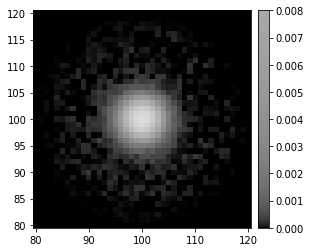

In [42]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
display1.mtv(psfimage)

Access the calibration object which can be used to convert instrumental magnitudes to AB magnitudes

In [43]:
calib = calexp.getPhotoCalib()
calib

PhotoCalib(spatially constant with mean: 0.660685 error: 0.000175435)

## Image cutouts

We can make a cutout from the calexp in our session.

In [44]:
import lsst.geom as afwGeom
import lsst.afw.image as afwImage

In [45]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(400,1400))
bbox.include(afwGeom.Point2I(600,1600))

cutout = calexp[bbox]

Notice that when the image is displayed, the pixel values relate to the parent image.

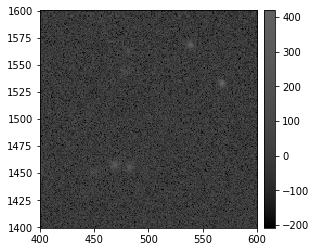

In [46]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(cutout.image)

The coordinate of the lower-left-hand pixel is XY0.

In [47]:
cutout.getXY0()

Point2I(400, 1400)

If a cutout was all that was desired from the start, we could have used our BoundingBox together with our Butler to have read in only the cutout.

In [48]:
cutout_calexp = butler.get('calexp_sub', bbox=bbox, dataId=dataId)
cutout_calexp.getDimensions()

Extent2I(201, 201)

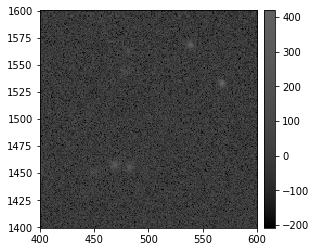

In [49]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(cutout_calexp.image)

The `clone` method makes a deep copy. The result can be sliced with a BoundingBox

In [50]:
clone_cutout = calexp.clone()[bbox]

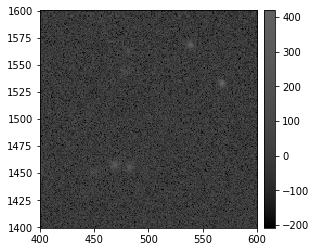

In [51]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.mtv(clone_cutout.image)

## Repeat for a coadd

For this last section, we will look at a coadd image.

Earlier, in the section "Retrieving and inspecting a calexp" above, we retrieved a coadd `calexp`.   Let's see here what methods it provides:

In [52]:
coadd_methods = [m for m in dir(coadd) if not m.startswith('_')]

In [53]:
coadd_methods

['Factory',
 'clone',
 'convertD',
 'convertF',
 'dtype',
 'getBBox',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 'image',
 'mask',
 'maskedImage',
 'readFits',
 'readFitsWithOptions',
 'setDetector',
 'setFilter',
 'setImage',
 'setInfo',
 'setMask',
 'setMaskedImage',
 'setMetadata',
 'setPhotoCalib',
 'setPsf',
 'setVariance',
 'setWcs',
 'setXY0',
 'subset',
 'variance',
 'writeFits',
 'writeFitsWithOptions']

In [54]:
set(coadd_methods).symmetric_difference(set(calexp_methods))

set()

The result of the `set` command above shows that a calexp and a coadd have the same methods. This is expected, because they are the same class.

In [55]:
print(calexp.__class__, coadd.__class__)

<class 'lsst.afw.image.exposure.exposure.ExposureF'> <class 'lsst.afw.image.exposure.exposure.ExposureF'>


A `deepCoadd_calexp` and a visit `calexp` differ mainly in the masks and the xy0 value.

In [56]:
calexp.mask.getMaskPlaneDict()

{'BAD': 0,
 'BRIGHT_OBJECT': 12,
 'CLIPPED': 13,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 10,
 'NO_DATA': 8,
 'REJECTED': 15,
 'SAT': 1,
 'SENSOR_EDGE': 16,
 'SUSPECT': 7,
 'UNMASKEDNAN': 11}

In [57]:
coadd.mask.getMaskPlaneDict()

{'BAD': 0,
 'BRIGHT_OBJECT': 12,
 'CLIPPED': 13,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 14,
 'INTRP': 2,
 'NOT_DEBLENDED': 10,
 'NO_DATA': 8,
 'REJECTED': 15,
 'SAT': 1,
 'SENSOR_EDGE': 16,
 'SUSPECT': 7,
 'UNMASKEDNAN': 11}

In [58]:
coadd.getXY0()

Point2I(3900, 15900)

Display the coadd with all masks visible.

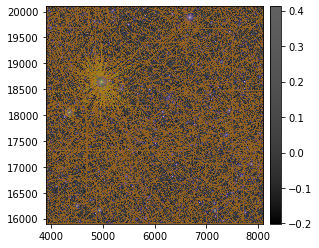

In [59]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.mtv(coadd)

Display the image data only with a zoom and pan to some nice-looking galaxies, to show off our hyperbolic arcsine stretch:

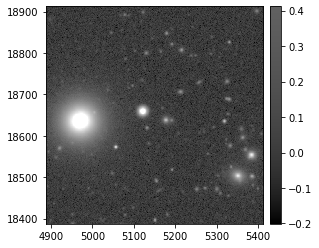

In [60]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("asinh", "zscale")
display1.mtv(coadd.image)
display1.zoom(16)
if dataset=='HSC':
    display1.pan(18700, 17000)
else:
    display1.pan(5150, 18650)